Loading intrinsic population
Computing GW limiting thresholds


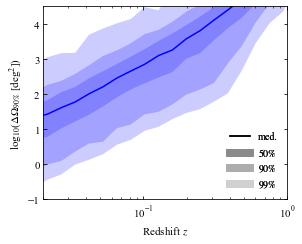

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.lines import Line2D
import corner
from functions_ET import * 
import warnings
warnings.filterwarnings("ignore")

# Plotting style
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.figsize'] = 4.3, 3.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["axes.axisbelow"] = False

# Load population
num = 1000000
eos = "SFHo"
mns_max = 2.058838

table = h5py.File(f'../horizons2/population/computed_population/nsns_{num}_{eos}_GWFAST.hdf5', 'r')

print("Loading intrinsic population")
m1 = table['m1'][()]
m2 = table['m2'][()]
z = table['z'][()]
thv = table['thv'][()]
m_dyn = table['m_dyn'][()]
m_disk = table['m_disk'][()]
m_gw = table['m_gw'][()]
snr_ETT = table['snr_ETT'][()]
sky_loc_ETT = table['sky_loc_ETT'][()]
table.close()

# Derived quantities
m_rem = m1 + m2 - m_gw - m_disk - m_dyn

# Weights
w_thv = np.sin(thv)
w_m1, w_m2 = mass_colombo22(m1, m2)
r0BNS = 347 / 1.85
r0BNS_high = (347 + 536) / 1.85
r0BNS_low = (347 - 256) / 1.85
w_z, w_z_high, w_z_low = redshift_weight(z, r0BNS, r0BNS_high, r0BNS_low)

w = w_m1 * w_m2 * w_z * w_thv
w_high = w_m1 * w_m2 * w_z_high * w_thv
w_low = w_m1 * w_m2 * w_z_low * w_thv

C_mc, C_mc_high, C_mc_low = monte_carlo_normalization(w, w_high, w_low, r0BNS, r0BNS_high, r0BNS_low)

# Limiting threshold
lim_snr = 12.
print("Computing GW limiting thresholds")
gw_det_ET = snr_ETT >= lim_snr
sky_loc_ET = sky_loc_ETT

# Data sorting
z_ord = np.sort(z)
ind_ord = np.argsort(z)
sky_loc_p = np.log10(sky_loc_ET[ind_ord])
weights_ord = w[ind_ord] * gw_det_ET[ind_ord] * ((m_dyn[ind_ord] > 1.e-6) | (m_disk[ind_ord] > 1.e-5))

# Remove NaNs
valid_indices = ~np.isnan(sky_loc_p)
z_ord = z_ord[valid_indices]
sky_loc_p = sky_loc_p[valid_indices]
weights_ord = weights_ord[valid_indices]

# Binning
num_bins = 30
bin_edges = np.logspace(np.log10(0.005), np.log10(4), num=num_bins + 1)
z_bin = (bin_edges[:-1] + bin_edges[1:]) / 2

sky_loc_final = []
weights_final = []
for i in range(num_bins):
    indices = np.where((z_ord >= bin_edges[i]) & (z_ord < bin_edges[i + 1]))[0]
    sky_loc_final.append(sky_loc_p[indices] if len(indices) > 0 else np.array([]))
    weights_final.append(weights_ord[indices] if len(indices) > 0 else np.array([]))

sky_loc_final = np.array(sky_loc_final, dtype=object)
weights_final = np.array(weights_final, dtype=object)

# Confidence intervals
perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
conf_curves = np.zeros([len(perc), len(z_bin)])

for i in range(len(z_bin)):
    if len(sky_loc_final[i]) > 1.e-2 and len(weights_final[i]) > 0:
        try:
            conf_curves[:, i] = corner.quantile(sky_loc_final[i], perc, weights=weights_final[i])
        except IndexError:
            conf_curves[:, i] = np.nan
    else:
        conf_curves[:, i] = np.nan

# Plot
for i, conf in enumerate([conf_curves]):
    plt.fill_between(z_bin, conf[0], conf[-1], edgecolor='None', facecolor="b", alpha=0.2)
    plt.fill_between(z_bin, conf[1], conf[-2], edgecolor='None', facecolor="b", alpha=0.2)
    plt.fill_between(z_bin, conf[2], conf[-3], edgecolor='None', facecolor="b", alpha=0.2)

leg1 = plt.legend(
    [Line2D([0], [0], color='black'),
     Line2D([0], [0], color='grey', lw=8, alpha=0.7),
     Line2D([0], [0], color='grey', lw=8, alpha=0.4),
     Line2D([0], [0], color='grey', lw=8, alpha=0.2)],
    ['med.', r'$50\%$', r'$90\%$', r'$99\%$'],
    loc=4, prop={'size': 10}, frameon=False
)
plt.gca().add_artist(leg1)

plt.plot(z_bin, conf[3], color="b")
plt.xscale("log")
plt.ylim(-1, 4.5)
plt.xlim(0.02, 1.)
plt.xlabel(r'Redshift $z$', size=11)
plt.ylabel(r"log$_{10}$($\Delta\Omega_{90\%}$ [deg$^2$])", size=11)
plt.tick_params(which='both', direction='in', left=True, bottom=True, top=True, right=True, labelsize=11)
plt.show()